# Import Modules

In [56]:
import importlib
import os
import sys

import joblib
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import sklearn.metrics as skm

os.chdir("../")
sys.path.insert(0, os.getcwd())

In [3]:
from morai.dashboard.utils import dashboard_helper as dh
from morai.experience import charters, credibility, eda, tables
from morai.forecast import metrics, models, preprocessors
from morai.utils import custom_logger, helpers

In [64]:
logger = custom_logger.setup_logging(__name__)

In [4]:
# update log level if wanting more logging
custom_logger.set_log_level("INFO")

In [5]:
pd.options.display.float_format = "{:,.2f}".format

# Load Data

In [102]:
pl_parquet_path = r"files/dataset/model_data.parquet"

In [103]:
# reading in the dataset
# `enable_string_cache` helps with categorical type values
pl.enable_string_cache()
lzdf = pl.scan_parquet(
    pl_parquet_path,
)

In [104]:
initial_row_count = lzdf.select(pl.len()).collect().item()
print(
    f"row count: {initial_row_count:,} \n"
    f"exposures: {lzdf.select([pl.col('amount_exposed').sum()]).collect()[0,0]:,}"
)

row count: 1,091,302 
exposures: 4,332,301,371,494.32


In [105]:
grouped_df = lzdf.collect()

In [106]:
grouped_df = grouped_df.to_pandas()

# Credibility

## Limited Fluctuation

 2024-07-08 23:35:33 | morai.experience.credibility | INFO     | Credibility calculated using 'limited fluctuation' on 'death_count'.
Dataframe does not need to be seriatim.
Created column 'credibility_lf'.
Full credibility threshold: 1,082.2
Probability measure within range: 0.9
Range +/-: 0.1
Standard deviation: 1.0
Mean: 1.0 


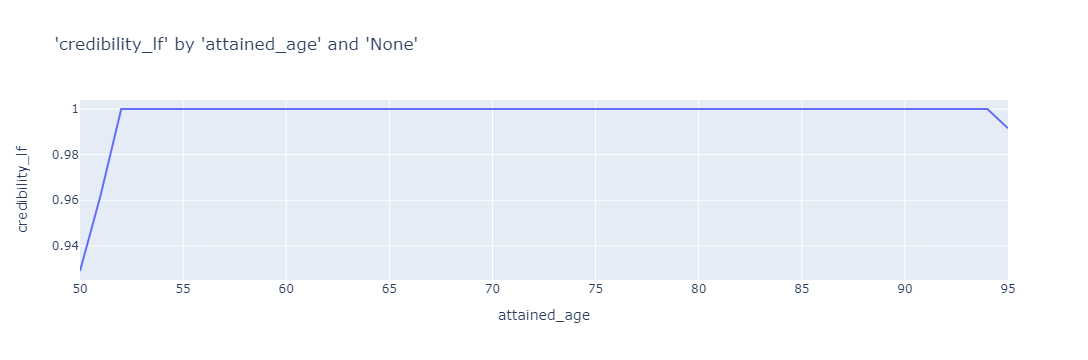

In [178]:
charters.chart(
    df=credibility.limited_fluctuation(
        df=grouped_df, measure="death_count", groupby_cols=["attained_age"]
    ),
    x_axis="attained_age",
    y_axis="credibility_lf",
    type="line",
)

## Asymptotic

 2024-07-08 23:34:19 | morai.experience.credibility | INFO     | Credibility calculated using 'asymptotic' on 'policies_exposed'.
Dataframe does not need to be seriatim.
Created column 'credibility_as'.
Constant k: 5000. 


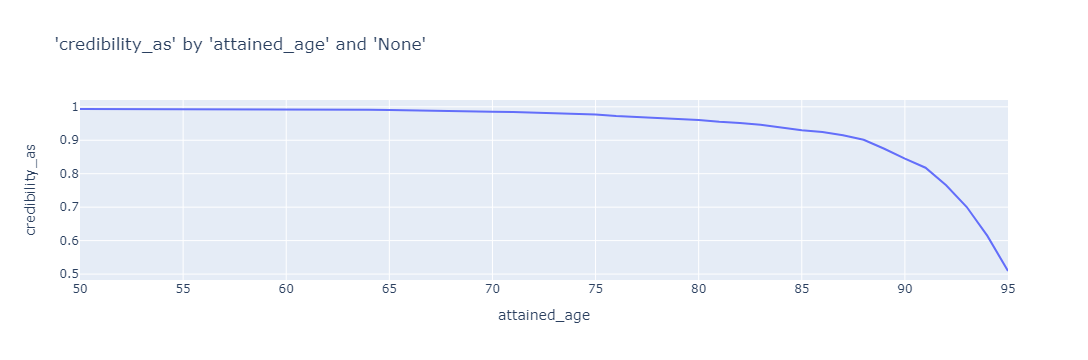

In [175]:
charters.chart(
    df=credibility.asymptotic(
        df=grouped_df, measure="policies_exposed", groupby_cols=["attained_age"], k=5000
    ),
    x_axis="attained_age",
    y_axis="credibility_as",
    type="line",
)

 2024-07-08 23:34:52 | morai.experience.credibility | INFO     | Credibility calculated using 'asymptotic' on 'policies_exposed'.
Dataframe does not need to be seriatim.
Created column 'credibility_as'.
Constant k: 5000. 


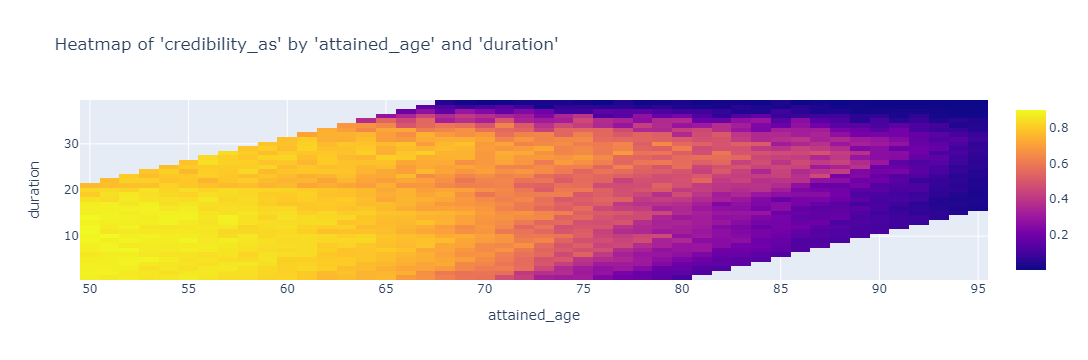

In [176]:
charters.chart(
    df=credibility.asymptotic(
        df=grouped_df, measure="policies_exposed", groupby_cols=["attained_age", "duration"], k=5000
    ),
    x_axis="attained_age",
    color="credibility_as",
    y_axis="duration",
    type="heatmap",
)

## VM20 Buhlmann

 2024-07-08 23:35:18 | morai.experience.credibility | INFO     | Credibility calculated using 'SOA VM-20 approximation'.
Created column 'credibility_vm20_approx'.
Dataframe does not need to be seriatim.
 


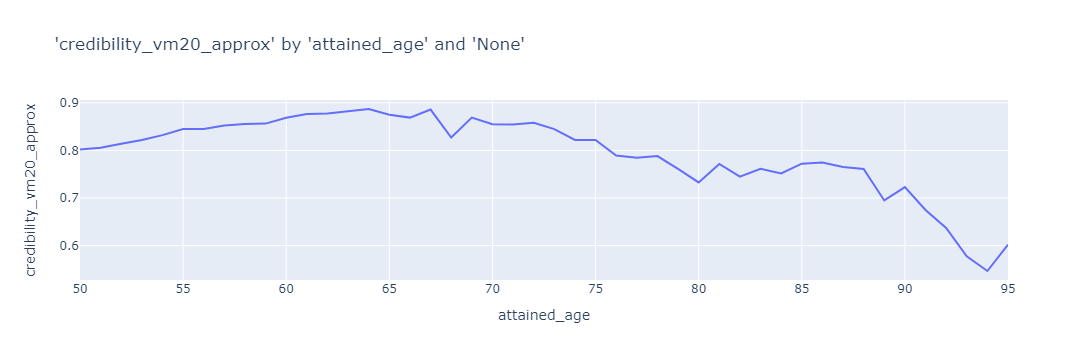

In [177]:
charters.chart(
    df=credibility.vm20_buhlmann_approx(
        df=grouped_df,
        a_col="exp_amt_vbt15",
        b_col="cen2momp1wmi_byamt",
        c_col="cen2momp2wmi_byamt",
        groupby_cols=["attained_age"],
    ),
    x_axis="attained_age",
    y_axis="credibility_vm20_approx",
    type="line",
)

# Relative Risk Table Fit

In [158]:
rates = [
    "vbt15_rr50",
    "vbt15_rr60",
    "vbt15_rr70",
    "vbt15_rr80",
    "vbt15_rr90",
    "vbt15",
    "vbt15_rr110",
]
for rate in rates:
    grouped_df = tables.map_rates(
        df=grouped_df,
        rate=rate,
        key_dict={
            "attained_age": "attained_age",
            "smoker_status": "smoker_status",
            "sex": "sex",
            "duration": "duration",
        },
    )

 2024-07-08 15:54:51 | morai.experience.tables | INFO     | mapping rate: 'qx_vbt15_rr50' with type: 'soa' 
 2024-07-08 15:54:53 | morai.experience.tables | INFO     | the mapped rates are based on the following keys: ['attained_age', 'smoker_status', 'sex', 'duration'] 
 2024-07-08 15:54:53 | morai.experience.tables | INFO     | mapping rate: 'qx_vbt15_rr60' with type: 'soa' 
 2024-07-08 15:54:55 | morai.experience.tables | INFO     | the mapped rates are based on the following keys: ['attained_age', 'smoker_status', 'sex', 'duration'] 
 2024-07-08 15:54:55 | morai.experience.tables | INFO     | mapping rate: 'qx_vbt15_rr70' with type: 'soa' 
 2024-07-08 15:54:58 | morai.experience.tables | INFO     | the mapped rates are based on the following keys: ['attained_age', 'smoker_status', 'sex', 'duration'] 
 2024-07-08 15:54:58 | morai.experience.tables | INFO     | mapping rate: 'qx_vbt15_rr80' with type: 'soa' 
 2024-07-08 15:54:59 | morai.experience.tables | INFO     | the mapped rates

In [167]:
result = []
filtered_df = grouped_df[grouped_df["class_enh"] == "4_4"]
for rate in rates:
    score = metrics.calculate_metrics(
        y_true=filtered_df["death_claim_amount"],
        y_pred=filtered_df["amount_exposed"] * filtered_df[f"qx_{rate}"],
        metrics=["r2_score", "smape", "mean_absolute_error"],
    )
    score["rate"] = rate
    result.append(score)
result = pd.DataFrame(result)
result = result.sort_values(by="_r2_score", ascending=False)
result

,_r2_score,_smape,_mean_absolute_error,rate
6,0.04,1.98,"22,627.62",vbt15_rr110
5,0.04,1.98,"21,896.49",vbt15
4,0.04,1.98,"21,073.69",vbt15_rr90
3,0.04,1.98,"20,418.78",vbt15_rr80
2,0.04,1.98,"19,770.27",vbt15_rr70
1,0.03,1.99,"19,014.25",vbt15_rr60
0,0.03,1.99,"18,257.96",vbt15_rr50


 2024-07-07 22:43:54 | morai.experience.charters | INFO     | The weights list is 1 long and should be 3 long. Using the first weight for all weights. 


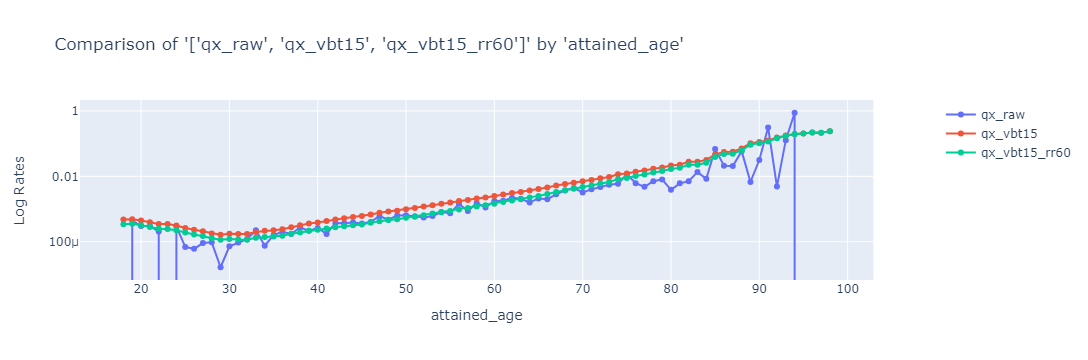

In [54]:
charters.compare_rates(
    df=filtered_df,
    x_axis="attained_age",
    rates=["qx_raw", "qx_vbt15", "qx_vbt15_rr60"],
    weights=["amount_exposed"],
    y_log=True,
    # x_bins=6,
    display=True,
)

# Importance

As seen in the feature selection, the most important variables from permutation were. For credibility calculations these will be split.
- attained age
- duration
- observation year (not statistically significant however)
- class
- faceband

In [151]:
model_name = "glm"

model_results = metrics.ModelResults(filepath='model_results.json')
feature_dict = model_results.model[model_results.model["model_name"] == model_name]["feature_dict"].iloc[0]

preprocess_dict = preprocessors.preprocess_data(
    grouped_df,
    feature_dict=feature_dict,
    standardize=False,
    add_constant=True,
)

X = preprocess_dict["X"]
y = preprocess_dict["y"]
weights = preprocess_dict["weights"]

GLM = models.GLM()
GLM.model = joblib.load(f"files/models/{model_name}.joblib")
logger.info(f"loaded model '{model_name}'. type: {type(GLM.model)}")
GLM.is_fitted_ = True

 2024-07-08 00:06:49 | morai.forecast.metrics | INFO     | loading results from C:\Users\johnk\Desktop\github\morai\files\result\model_results.json 
 2024-07-08 00:06:49 | morai.forecast.preprocessors | INFO     | model target: ['qx_raw'] 
 2024-07-08 00:06:49 | morai.forecast.preprocessors | INFO     | model weights: ['amount_exposed'] 
 2024-07-08 00:06:49 | morai.forecast.preprocessors | INFO     | adding a constant column to the data 
 2024-07-08 00:06:49 | morai.forecast.preprocessors | INFO     | passthrough - (generally numeric): ['duration', 'attained_age', 'observation_year', 'constant'] 
 2024-07-08 00:06:49 | morai.forecast.preprocessors | INFO     | ordinal - ordinal encoded: ['smoker_status', 'sex'] 
 2024-07-08 00:06:50 | morai.forecast.preprocessors | INFO     | nominal - one hot encoded (dropping first col): ['insurance_plan', 'binned_face', 'class_enh'] 
 2024-07-08 00:06:54 | __main__ | INFO     | loaded model 'glm'. type: <class 'statsmodels.genmod.generalized_linear

In [152]:
odds = GLM.get_odds()

In [156]:
pivot_list = []
for feature in feature_dict['ohe']:
    pivot_df = grouped_df.pivot_table(values='death_count', index=feature, aggfunc='sum', observed=False).reset_index()
    pivot_df['column'] = feature
    pivot_df = pivot_df.rename(columns={feature: 'value'})
    pivot_df = pivot_df[['column', 'value', 'death_count']]
    pivot_df['odds'] = pivot_df.apply(lambda row: odds.get(f"{feature}_{row['value']}", None), axis=1)
    pivot_list.append(pivot_df)
result_df = pd.concat(pivot_list, ignore_index=True)
result_df.sort_values(by='odds')

,column,value,death_count,odds
16,class_enh,4_1,2232,0.64
4,binned_face,"05: 5,000,000+",341,0.66
3,binned_face,"04: 250,000 - 4,999,999",17335,0.73
13,class_enh,3_1,2244,0.74
2,binned_face,"03: 100,000 - 249,999",29853,0.77
17,class_enh,4_2,2235,0.79
14,class_enh,3_2,3192,0.80
1,binned_face,"02: 25,000 - 99,999",54530,0.85
18,class_enh,4_3,1594,0.97
20,class_enh,NA_NA,105882,1.04


In [ ]:
GLM.get_feature_contributions(X, y, weights=weights)

# Reload

In [14]:
importlib.reload(tables)

<module 'morai.experience.tables' from 'C:\\Users\\johnk\\Desktop\\github\\morai\\morai\\experience\\tables.py'>

In [37]:
importlib.reload(metrics)

<module 'morai.forecast.metrics' from 'C:\\Users\\johnk\\Desktop\\github\\morai\\morai\\forecast\\metrics.py'>

# Utilities

In [69]:
helpers.memory_usage_jupyter(globals=globals()).head(10)

,object,size_mb
0,grouped_df,171.30
1,corr,0.00
2,nan_counts,0.00
3,desc,0.00
4,columns_needed,0.00
5,columns_not_needed,0.00
6,variables,0.00
7,pl_parquet_path,0.00
8,open,0.00
9,measures,0.00
